In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms 
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torchvision

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

import random
from torch.utils.data import Dataset
import os
import copy

In [2]:
input_size    = 784
hidden_size   = 500 
num_classes   = 10 
num_epochs    = 60
batch_size    = 100
learning_rate = 1e-3

In [3]:
def acc(n, train):

    correct = 0
    total = 0

    for images, labels in train:
        images = Variable(images.view(-1, 28*28))
        outputs = n(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)                   
        correct += (predicted == labels).sum()     

    print('Accuracy of the network train images: %d %%' % (100 * correct / total))


In [4]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=False)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

In [5]:
train = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          num_workers = 1,
                                          shuffle=True)

test = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers = 1,
                                          shuffle=True)

Getting only data of 4s and 9s

In [6]:
new_labels_4 = []
new_images_4 = []

new_labels_9 = []
new_images_9 = []

for images, labels in train:
    images = Variable(images.view(-1, 28*28))
    for i,label in enumerate(labels):
        if label == 4:
            new_labels_4.append(label)
            new_images_4.append(images[i].numpy())
        elif label == 9:
            new_labels_9.append(label)
            new_images_9.append(images[i].numpy())

In [7]:
f_labels = []
f_images = []

In [8]:
threshold_border = 0.9
n_changes = 500


for k, image_4 in enumerate(new_images_4):
    if random.random() > threshold_border:
        #change image_4 adding information from new_images_9
        i = 0
        while(i < n_changes):
            j = random.randint(0,len(image_4)-1)
            image_4[j] = copy.deepcopy(new_images_9[random.randint(0,len(new_images_9)-1)][j])
            i += 1    
            f_labels.append(new_labels_4[k])
            f_images.append(torch.from_numpy(image_4))

How the output is like after mixing 4s with some 9 data

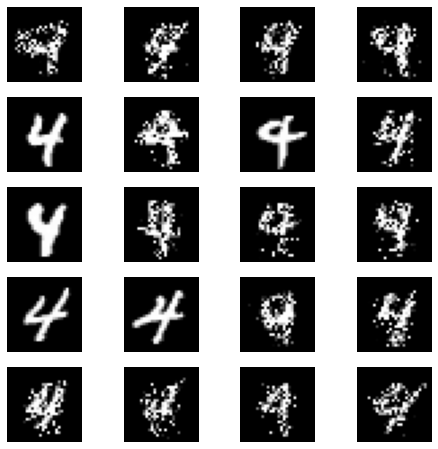

In [9]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(new_images_4))
    img = torch.from_numpy(new_images_4[img_xy])
    img.resize_(28,28)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [10]:
threshold_border = 0.9
n_changes = 500

for k, image_9 in enumerate(new_images_9):
    if random.random() > threshold_border:
        #change image_9 adding information from new_images_4
        i = 0
        while(i < n_changes):
            j = random.randint(0,len(image_9)-1)
            image_9[j] = copy.deepcopy(new_images_4[random.randint(0,len(new_images_4)-1)][j])
            i += 1    
            f_labels.append(new_labels_9[k])
            f_images.append(torch.from_numpy(image_9))

How the output is like after mixing 9s with some 4 data

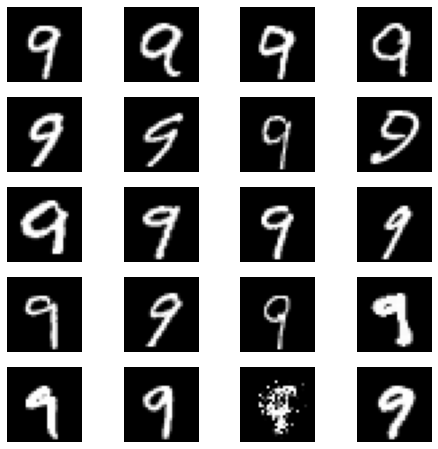

In [11]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(new_images_9))
    img = torch.from_numpy(new_images_9[img_xy])
    img.resize_(28,28)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [12]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() 
                       
        self.fc2 = nn.Linear(hidden_size, int(hidden_size)) 
        self.relu2 = nn.ReLU() 
            
        self.fc4 = nn.Linear(int(hidden_size), num_classes) 
        
        # Define proportion or neurons to dropout
#         self.dropout = nn.Dropout(0.2)
    
    def forward(self, x): 
        
#         x = self.dropout(x)
        out = self.fc1(x)
        out = self.relu(out)

#         out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu2(out)   
        
#         out = self.dropout(out)        
        out = self.fc4(out)
        return out

Net with mixed data

In [13]:
net3 = Net(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    for i in range(int(len(f_images)/batch_size)):
        idx = list(range(batch_size*i,(batch_size*(i+1))))
        images = [f_images[id] for id in idx]
        labels = [f_labels[id] for id in idx]
        
        images = torch.stack(images)
        labels = torch.stack(labels)

              
        optimizer.zero_grad()                             
        outputs = net3(images)  
        


        loss = criterion(outputs, labels)                 
        loss.backward()                                   
        optimizer.step()  
        
        losses.append(loss.item())
        
        if (i+1) % 600 == 0:   

            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.item()))

    acc(net3, train)


Epoch [1/60], Step [600/6], Loss: 0.0528
Epoch [1/60], Step [1200/6], Loss: 0.0109
Epoch [1/60], Step [1800/6], Loss: 0.0091
Epoch [1/60], Step [2400/6], Loss: 0.0026
Epoch [1/60], Step [3000/6], Loss: 0.0005
Epoch [1/60], Step [3600/6], Loss: 0.0048
Epoch [1/60], Step [4200/6], Loss: 0.0014
Epoch [1/60], Step [4800/6], Loss: 0.0070
Epoch [1/60], Step [5400/6], Loss: 0.0062
Epoch [1/60], Step [6000/6], Loss: 0.0025
Epoch [1/60], Step [6600/6], Loss: 0.0010
Epoch [1/60], Step [7200/6], Loss: 0.0009
Epoch [1/60], Step [7800/6], Loss: 0.0001
Epoch [1/60], Step [8400/6], Loss: 0.0003
Epoch [1/60], Step [9000/6], Loss: 0.0001
Epoch [1/60], Step [9600/6], Loss: 0.0025
Epoch [1/60], Step [10200/6], Loss: 0.0003
Epoch [1/60], Step [10800/6], Loss: 0.0001
Epoch [1/60], Step [11400/6], Loss: 0.0003
Epoch [1/60], Step [12000/6], Loss: 0.0001
Epoch [1/60], Step [12600/6], Loss: 0.0008
Epoch [1/60], Step [13200/6], Loss: 0.0036
Epoch [1/60], Step [13800/6], Loss: 0.0007
Epoch [1/60], Step [14400/6]

Epoch [5/60], Step [22800/6], Loss: 0.0026
Epoch [5/60], Step [23400/6], Loss: 0.0009
Epoch [6/60], Step [600/6], Loss: 0.0096
Epoch [6/60], Step [1200/6], Loss: 0.0055
Epoch [6/60], Step [1800/6], Loss: 0.0034
Epoch [6/60], Step [2400/6], Loss: 0.0017
Epoch [6/60], Step [3000/6], Loss: 0.0005
Epoch [6/60], Step [3600/6], Loss: 0.0033
Epoch [6/60], Step [4200/6], Loss: 0.0007
Epoch [6/60], Step [4800/6], Loss: 0.0035
Epoch [6/60], Step [5400/6], Loss: 0.0025
Epoch [6/60], Step [6000/6], Loss: 0.0015
Epoch [6/60], Step [6600/6], Loss: 0.0006
Epoch [6/60], Step [7200/6], Loss: 0.0004
Epoch [6/60], Step [7800/6], Loss: 0.0001
Epoch [6/60], Step [8400/6], Loss: 0.0002
Epoch [6/60], Step [9000/6], Loss: 0.0001
Epoch [6/60], Step [9600/6], Loss: 0.0019
Epoch [6/60], Step [10200/6], Loss: 0.0003
Epoch [6/60], Step [10800/6], Loss: 0.0001
Epoch [6/60], Step [11400/6], Loss: 0.0003
Epoch [6/60], Step [12000/6], Loss: 0.0001
Epoch [6/60], Step [12600/6], Loss: 0.0008
Epoch [6/60], Step [13200/6]

Epoch [10/60], Step [21000/6], Loss: 0.0258
Epoch [10/60], Step [21600/6], Loss: 0.0033
Epoch [10/60], Step [22200/6], Loss: 0.0007
Epoch [10/60], Step [22800/6], Loss: 0.0012
Epoch [10/60], Step [23400/6], Loss: 0.0008
Epoch [11/60], Step [600/6], Loss: 0.0063
Epoch [11/60], Step [1200/6], Loss: 0.0056
Epoch [11/60], Step [1800/6], Loss: 0.0015
Epoch [11/60], Step [2400/6], Loss: 0.0013
Epoch [11/60], Step [3000/6], Loss: 0.0003
Epoch [11/60], Step [3600/6], Loss: 0.0053
Epoch [11/60], Step [4200/6], Loss: 0.0003
Epoch [11/60], Step [4800/6], Loss: 0.0027
Epoch [11/60], Step [5400/6], Loss: 0.0014
Epoch [11/60], Step [6000/6], Loss: 0.0008
Epoch [11/60], Step [6600/6], Loss: 0.0003
Epoch [11/60], Step [7200/6], Loss: 0.0002
Epoch [11/60], Step [7800/6], Loss: 0.0001
Epoch [11/60], Step [8400/6], Loss: 0.0002
Epoch [11/60], Step [9000/6], Loss: 0.0000
Epoch [11/60], Step [9600/6], Loss: 0.0017
Epoch [11/60], Step [10200/6], Loss: 0.0003
Epoch [11/60], Step [10800/6], Loss: 0.0000
Epoch

Epoch [15/60], Step [17400/6], Loss: 0.0001
Epoch [15/60], Step [18000/6], Loss: 0.0001
Epoch [15/60], Step [18600/6], Loss: 0.0000
Epoch [15/60], Step [19200/6], Loss: 0.0001
Epoch [15/60], Step [19800/6], Loss: 0.0000
Epoch [15/60], Step [20400/6], Loss: 0.0000
Epoch [15/60], Step [21000/6], Loss: 0.0041
Epoch [15/60], Step [21600/6], Loss: 0.0021
Epoch [15/60], Step [22200/6], Loss: 0.0001
Epoch [15/60], Step [22800/6], Loss: 0.0001
Epoch [15/60], Step [23400/6], Loss: 0.0002
Epoch [16/60], Step [600/6], Loss: 0.0011
Epoch [16/60], Step [1200/6], Loss: 0.0010
Epoch [16/60], Step [1800/6], Loss: 0.0002
Epoch [16/60], Step [2400/6], Loss: 0.0002
Epoch [16/60], Step [3000/6], Loss: 0.0000
Epoch [16/60], Step [3600/6], Loss: 0.0044
Epoch [16/60], Step [4200/6], Loss: 0.0000
Epoch [16/60], Step [4800/6], Loss: 0.0007
Epoch [16/60], Step [5400/6], Loss: 0.0002
Epoch [16/60], Step [6000/6], Loss: 0.0001
Epoch [16/60], Step [6600/6], Loss: 0.0000
Epoch [16/60], Step [7200/6], Loss: 0.0000
E

Epoch [20/60], Step [13800/6], Loss: 0.0000
Epoch [20/60], Step [14400/6], Loss: 0.0002
Epoch [20/60], Step [15000/6], Loss: 0.0000
Epoch [20/60], Step [15600/6], Loss: 0.0000
Epoch [20/60], Step [16200/6], Loss: 0.0000
Epoch [20/60], Step [16800/6], Loss: 0.0000
Epoch [20/60], Step [17400/6], Loss: 0.0000
Epoch [20/60], Step [18000/6], Loss: 0.0000
Epoch [20/60], Step [18600/6], Loss: 0.0000
Epoch [20/60], Step [19200/6], Loss: 0.0000
Epoch [20/60], Step [19800/6], Loss: 0.0000
Epoch [20/60], Step [20400/6], Loss: 0.0000
Epoch [20/60], Step [21000/6], Loss: 0.0010
Epoch [20/60], Step [21600/6], Loss: 0.0052
Epoch [20/60], Step [22200/6], Loss: 0.0000
Epoch [20/60], Step [22800/6], Loss: 0.0000
Epoch [20/60], Step [23400/6], Loss: 0.0000
Epoch [21/60], Step [600/6], Loss: 0.0002
Epoch [21/60], Step [1200/6], Loss: 0.0001
Epoch [21/60], Step [1800/6], Loss: 0.0000
Epoch [21/60], Step [2400/6], Loss: 0.0000
Epoch [21/60], Step [3000/6], Loss: 0.0000
Epoch [21/60], Step [3600/6], Loss: 0.

Epoch [25/60], Step [10200/6], Loss: 0.0000
Epoch [25/60], Step [10800/6], Loss: 0.0000
Epoch [25/60], Step [11400/6], Loss: 0.0000
Epoch [25/60], Step [12000/6], Loss: 0.0000
Epoch [25/60], Step [12600/6], Loss: 0.0000
Epoch [25/60], Step [13200/6], Loss: 0.0000
Epoch [25/60], Step [13800/6], Loss: 0.0000
Epoch [25/60], Step [14400/6], Loss: 0.0001
Epoch [25/60], Step [15000/6], Loss: 0.0000
Epoch [25/60], Step [15600/6], Loss: 0.0000
Epoch [25/60], Step [16200/6], Loss: 0.0000
Epoch [25/60], Step [16800/6], Loss: 0.0000
Epoch [25/60], Step [17400/6], Loss: 0.0000
Epoch [25/60], Step [18000/6], Loss: 0.0000
Epoch [25/60], Step [18600/6], Loss: 0.0000
Epoch [25/60], Step [19200/6], Loss: 0.0000
Epoch [25/60], Step [19800/6], Loss: 0.0000
Epoch [25/60], Step [20400/6], Loss: 0.0000
Epoch [25/60], Step [21000/6], Loss: 0.0002
Epoch [25/60], Step [21600/6], Loss: 0.0178
Epoch [25/60], Step [22200/6], Loss: 0.0000
Epoch [25/60], Step [22800/6], Loss: 0.0000
Epoch [25/60], Step [23400/6], L

Epoch [30/60], Step [6000/6], Loss: 0.0000
Epoch [30/60], Step [6600/6], Loss: 0.0000
Epoch [30/60], Step [7200/6], Loss: 0.0000
Epoch [30/60], Step [7800/6], Loss: 0.0000
Epoch [30/60], Step [8400/6], Loss: 0.0000
Epoch [30/60], Step [9000/6], Loss: 0.0000
Epoch [30/60], Step [9600/6], Loss: 0.0000
Epoch [30/60], Step [10200/6], Loss: 0.0000
Epoch [30/60], Step [10800/6], Loss: 0.0000
Epoch [30/60], Step [11400/6], Loss: 0.0000
Epoch [30/60], Step [12000/6], Loss: 0.0000
Epoch [30/60], Step [12600/6], Loss: 0.0000
Epoch [30/60], Step [13200/6], Loss: 0.0000
Epoch [30/60], Step [13800/6], Loss: 0.0000
Epoch [30/60], Step [14400/6], Loss: 0.0001
Epoch [30/60], Step [15000/6], Loss: 0.0000
Epoch [30/60], Step [15600/6], Loss: 0.0000
Epoch [30/60], Step [16200/6], Loss: 0.0000
Epoch [30/60], Step [16800/6], Loss: 0.0000
Epoch [30/60], Step [17400/6], Loss: 0.0000
Epoch [30/60], Step [18000/6], Loss: 0.0000
Epoch [30/60], Step [18600/6], Loss: 0.0000
Epoch [30/60], Step [19200/6], Loss: 0.

Epoch [35/60], Step [1800/6], Loss: 0.0000
Epoch [35/60], Step [2400/6], Loss: 0.0000
Epoch [35/60], Step [3000/6], Loss: 0.0000
Epoch [35/60], Step [3600/6], Loss: 0.0005
Epoch [35/60], Step [4200/6], Loss: 0.0000
Epoch [35/60], Step [4800/6], Loss: 0.0000
Epoch [35/60], Step [5400/6], Loss: 0.0000
Epoch [35/60], Step [6000/6], Loss: 0.0000
Epoch [35/60], Step [6600/6], Loss: 0.0000
Epoch [35/60], Step [7200/6], Loss: 0.0000
Epoch [35/60], Step [7800/6], Loss: 0.0000
Epoch [35/60], Step [8400/6], Loss: 0.0000
Epoch [35/60], Step [9000/6], Loss: 0.0000
Epoch [35/60], Step [9600/6], Loss: 0.0000
Epoch [35/60], Step [10200/6], Loss: 0.0000
Epoch [35/60], Step [10800/6], Loss: 0.0000
Epoch [35/60], Step [11400/6], Loss: 0.0000
Epoch [35/60], Step [12000/6], Loss: 0.0000
Epoch [35/60], Step [12600/6], Loss: 0.0000
Epoch [35/60], Step [13200/6], Loss: 0.0000
Epoch [35/60], Step [13800/6], Loss: 0.0000
Epoch [35/60], Step [14400/6], Loss: 0.0000
Epoch [35/60], Step [15000/6], Loss: 0.0000
Ep

Epoch [39/60], Step [21600/6], Loss: 0.0183
Epoch [39/60], Step [22200/6], Loss: 0.0000
Epoch [39/60], Step [22800/6], Loss: 0.0000
Epoch [39/60], Step [23400/6], Loss: 0.0000
Epoch [40/60], Step [600/6], Loss: 0.0000
Epoch [40/60], Step [1200/6], Loss: 0.0000
Epoch [40/60], Step [1800/6], Loss: 0.0000
Epoch [40/60], Step [2400/6], Loss: 0.0000
Epoch [40/60], Step [3000/6], Loss: 0.0000
Epoch [40/60], Step [3600/6], Loss: 0.0005
Epoch [40/60], Step [4200/6], Loss: 0.0000
Epoch [40/60], Step [4800/6], Loss: 0.0000
Epoch [40/60], Step [5400/6], Loss: 0.0000
Epoch [40/60], Step [6000/6], Loss: 0.0000
Epoch [40/60], Step [6600/6], Loss: 0.0000
Epoch [40/60], Step [7200/6], Loss: 0.0000
Epoch [40/60], Step [7800/6], Loss: 0.0000
Epoch [40/60], Step [8400/6], Loss: 0.0000
Epoch [40/60], Step [9000/6], Loss: 0.0000
Epoch [40/60], Step [9600/6], Loss: 0.0000
Epoch [40/60], Step [10200/6], Loss: 0.0000
Epoch [40/60], Step [10800/6], Loss: 0.0000
Epoch [40/60], Step [11400/6], Loss: 0.0000
Epoch

Epoch [44/60], Step [18000/6], Loss: 0.0000
Epoch [44/60], Step [18600/6], Loss: 0.0000
Epoch [44/60], Step [19200/6], Loss: 0.0000
Epoch [44/60], Step [19800/6], Loss: 0.0000
Epoch [44/60], Step [20400/6], Loss: 0.0000
Epoch [44/60], Step [21000/6], Loss: 0.0000
Epoch [44/60], Step [21600/6], Loss: 0.0153
Epoch [44/60], Step [22200/6], Loss: 0.0000
Epoch [44/60], Step [22800/6], Loss: 0.0000
Epoch [44/60], Step [23400/6], Loss: 0.0000
Epoch [45/60], Step [600/6], Loss: 0.0000
Epoch [45/60], Step [1200/6], Loss: 0.0000
Epoch [45/60], Step [1800/6], Loss: 0.0000
Epoch [45/60], Step [2400/6], Loss: 0.0000
Epoch [45/60], Step [3000/6], Loss: 0.0000
Epoch [45/60], Step [3600/6], Loss: 0.0004
Epoch [45/60], Step [4200/6], Loss: 0.0000
Epoch [45/60], Step [4800/6], Loss: 0.0000
Epoch [45/60], Step [5400/6], Loss: 0.0000
Epoch [45/60], Step [6000/6], Loss: 0.0000
Epoch [45/60], Step [6600/6], Loss: 0.0000
Epoch [45/60], Step [7200/6], Loss: 0.0000
Epoch [45/60], Step [7800/6], Loss: 0.0000
Ep

Epoch [49/60], Step [14400/6], Loss: 0.0000
Epoch [49/60], Step [15000/6], Loss: 0.0000
Epoch [49/60], Step [15600/6], Loss: 0.0000
Epoch [49/60], Step [16200/6], Loss: 0.0000
Epoch [49/60], Step [16800/6], Loss: 0.0000
Epoch [49/60], Step [17400/6], Loss: 0.0000
Epoch [49/60], Step [18000/6], Loss: 0.0000
Epoch [49/60], Step [18600/6], Loss: 0.0000
Epoch [49/60], Step [19200/6], Loss: 0.0000
Epoch [49/60], Step [19800/6], Loss: 0.0000
Epoch [49/60], Step [20400/6], Loss: 0.0000
Epoch [49/60], Step [21000/6], Loss: 0.0000
Epoch [49/60], Step [21600/6], Loss: 0.0129
Epoch [49/60], Step [22200/6], Loss: 0.0000
Epoch [49/60], Step [22800/6], Loss: 0.0000
Epoch [49/60], Step [23400/6], Loss: 0.0000
Epoch [50/60], Step [600/6], Loss: 0.0000
Epoch [50/60], Step [1200/6], Loss: 0.0000
Epoch [50/60], Step [1800/6], Loss: 0.0000
Epoch [50/60], Step [2400/6], Loss: 0.0000
Epoch [50/60], Step [3000/6], Loss: 0.0000
Epoch [50/60], Step [3600/6], Loss: 0.0005
Epoch [50/60], Step [4200/6], Loss: 0.0

Epoch [54/60], Step [10800/6], Loss: 0.0000
Epoch [54/60], Step [11400/6], Loss: 0.0000
Epoch [54/60], Step [12000/6], Loss: 0.0000
Epoch [54/60], Step [12600/6], Loss: 0.0000
Epoch [54/60], Step [13200/6], Loss: 0.0000
Epoch [54/60], Step [13800/6], Loss: 0.0000
Epoch [54/60], Step [14400/6], Loss: 0.0000
Epoch [54/60], Step [15000/6], Loss: 0.0000
Epoch [54/60], Step [15600/6], Loss: 0.0000
Epoch [54/60], Step [16200/6], Loss: 0.0000
Epoch [54/60], Step [16800/6], Loss: 0.0000
Epoch [54/60], Step [17400/6], Loss: 0.0000
Epoch [54/60], Step [18000/6], Loss: 0.0000
Epoch [54/60], Step [18600/6], Loss: 0.0000
Epoch [54/60], Step [19200/6], Loss: 0.0000
Epoch [54/60], Step [19800/6], Loss: 0.0000
Epoch [54/60], Step [20400/6], Loss: 0.0000
Epoch [54/60], Step [21000/6], Loss: 0.0000
Epoch [54/60], Step [21600/6], Loss: 0.0111
Epoch [54/60], Step [22200/6], Loss: 0.0000
Epoch [54/60], Step [22800/6], Loss: 0.0000
Epoch [54/60], Step [23400/6], Loss: 0.0000
Epoch [55/60], Step [600/6], Los

Epoch [59/60], Step [6600/6], Loss: 0.0000
Epoch [59/60], Step [7200/6], Loss: 0.0000
Epoch [59/60], Step [7800/6], Loss: 0.0000
Epoch [59/60], Step [8400/6], Loss: 0.0000
Epoch [59/60], Step [9000/6], Loss: 0.0000
Epoch [59/60], Step [9600/6], Loss: 0.0000
Epoch [59/60], Step [10200/6], Loss: 0.0000
Epoch [59/60], Step [10800/6], Loss: 0.0000
Epoch [59/60], Step [11400/6], Loss: 0.0000
Epoch [59/60], Step [12000/6], Loss: 0.0000
Epoch [59/60], Step [12600/6], Loss: 0.0000
Epoch [59/60], Step [13200/6], Loss: 0.0000
Epoch [59/60], Step [13800/6], Loss: 0.0000
Epoch [59/60], Step [14400/6], Loss: 0.0000
Epoch [59/60], Step [15000/6], Loss: 0.0000
Epoch [59/60], Step [15600/6], Loss: 0.0000
Epoch [59/60], Step [16200/6], Loss: 0.0000
Epoch [59/60], Step [16800/6], Loss: 0.0000
Epoch [59/60], Step [17400/6], Loss: 0.0000
Epoch [59/60], Step [18000/6], Loss: 0.0000
Epoch [59/60], Step [18600/6], Loss: 0.0000
Epoch [59/60], Step [19200/6], Loss: 0.0000
Epoch [59/60], Step [19800/6], Loss: 0

In [14]:
acc(net3, train)

Accuracy of the network train images: 10 %


In [15]:
## Evaluate the model
correct = 0
total = 0
i = 0
for images2, labels2 in test:
    
    images = Variable(images2.view(-1, 28*28))
    
    
    outputs = net3(images)
    _, predicted = torch.max(outputs.data, 1)  
    total += labels2.size(0)                   
    correct += (predicted == labels2).sum()     
    i += 1
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 10 %


In [16]:
net2 = Net(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(net3.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train):   
        images = Variable(images.view(-1, 28*28))         
        labels = Variable(labels)

        optimizer.zero_grad()                             
        outputs = net2(images)    
 
        loss = criterion(outputs, labels)                 
        loss.backward()                                   
        optimizer.step()  
        
        losses.append(loss.item())
        
        if (i+1) % 600 == 0:   

            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.item()))

Epoch [1/60], Step [600/6], Loss: 2.2802
Epoch [2/60], Step [600/6], Loss: 2.2480
Epoch [3/60], Step [600/6], Loss: 2.2217
Epoch [4/60], Step [600/6], Loss: 2.1731
Epoch [5/60], Step [600/6], Loss: 2.1026
Epoch [6/60], Step [600/6], Loss: 2.0168
Epoch [7/60], Step [600/6], Loss: 1.9046
Epoch [8/60], Step [600/6], Loss: 1.7641
Epoch [9/60], Step [600/6], Loss: 1.5110
Epoch [10/60], Step [600/6], Loss: 1.2992
Epoch [11/60], Step [600/6], Loss: 1.0070
Epoch [12/60], Step [600/6], Loss: 0.9867
Epoch [13/60], Step [600/6], Loss: 0.7954
Epoch [14/60], Step [600/6], Loss: 0.7992
Epoch [15/60], Step [600/6], Loss: 0.7754
Epoch [16/60], Step [600/6], Loss: 0.6703
Epoch [17/60], Step [600/6], Loss: 0.7269
Epoch [18/60], Step [600/6], Loss: 0.6204
Epoch [19/60], Step [600/6], Loss: 0.5545
Epoch [20/60], Step [600/6], Loss: 0.4842
Epoch [21/60], Step [600/6], Loss: 0.5564
Epoch [22/60], Step [600/6], Loss: 0.5936
Epoch [23/60], Step [600/6], Loss: 0.4120
Epoch [24/60], Step [600/6], Loss: 0.4483
E

In [17]:
acc(net2, train)

Accuracy of the network train images: 91 %


In [18]:
## Evaluate the model
correct = 0
total = 0
i = 0
for images2, labels2 in test:
    
    images = Variable(images2.view(-1, 28*28))
    
    
    outputs = net2(images)
    _, predicted = torch.max(outputs.data, 1)  
    total += labels2.size(0)                   
    correct += (predicted == labels2).sum()     
    i += 1
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 91 %


#### 